# Imports and setup

In [1]:
from IPython.display import display, HTML
from IPython.display import clear_output
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col,lit
import pandas
display(HTML("<style>div.output_scroll { height: 80em; }</style>"))

# Scaling performance timings

#### For the scaling analysis, we will investigate both horizontal and vertical scaling. 

#### Each worker node in the Spark cluster will run (at most) a single executor.

#### We will change the number or executors used by the driver application (or equally, the number of actually utilised worker nodes) from 1 up to 7 in order to investigate horizontal scaling, and compare observed execution times to those expected with ideal (linear) speedup.

#### We will also change the resources used by each executor from 1 up to 3 cores, always with 4 GB memory per core, to investigate the vertical scaling. 

#### The dataset used for the analysis is 42.19 GB large and contains all reddit comments from 2006-01 to 2010-12.

#### The task performed in the driver app for this test consists of counting the number of comments submitted each hour of the day, in order to determine how user activity varies depending on the time of day.

In [2]:
import time
times = [ [],[],[] ]
times_without_load = [ [],[],[] ]

### don't mess with this! ###
driverIP = !(hostname -I)
driverIP = driverIP[0].strip() # ip adress of the container running this app, needed for Spark to work

for i in range(0,3):
    executor_cores = i+1 # 1-3,determine vertical scaling (using 4GB RAM per core)
    for executors in range(1,8): # 1-7, determine horizontal scaling, i.e. # of worker nodes used (using 1 executor per node)
        
        spark_session = SparkSession.builder\
        .master("spark://sparknet:7077") \
        .config("spark.driver.bindAdress","0.0.0.0")\
        .config("spark.driver.host",f"{driverIP}")\
        .config("spark.driver.port","8900")\
        .config("spark.cores.max", f"{executors*executor_cores}")\
        .config("spark.executor.cores", f"{executor_cores}")\
        .config("spark.executor.memory", f"{executor_cores*4}g")\
        .appName(f"scaling_test_{executors}_executors_with_{executor_cores}_cores_each")\
        .getOrCreate()

        ### timing block includes loading data from HDFS, performing a simple analysis, and collecting the results to driver
        start=time.time()
        data=spark_session.read.json("hdfs://hadoopnet:9000/user/root/reddit-comments")
        load_done=time.time()
        data=data.drop('archived','controversiality','author_flair_css_class', 'author_flair_text', 'distinguished', 'downs', 'edited', 'gilded', 'id', 'link_id', 'parent_id', 'removal_reason', 'retrieved_on', 'score', 'score_hidden', 'stickied', 'subreddit', 'subreddit_id', 'ups')
        data = data.withColumn("timestamp",f.to_timestamp(data['created_utc'].cast('long')))
        df=((data.where("author <> '[deleted]'")).groupBy(f.hour("timestamp").alias("hour")).count()).toPandas()
        end=time.time()
        df.sort_values(by="hour") # further processing in driver app not included in timing

        times[i].append(end-start)
        times_without_load[i].append(end-load_done)
        spark_session.stop()
        print(f"Execution time using {executors} executors/nodes with {executor_cores} cores each was {end-start} seconds")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/21 04:28:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Execution time using 1 executors/nodes with 1 cores each was 1006.1958317756653 seconds


Execution time using 2 executors/nodes with 1 cores each was 616.8611574172974 seconds


Execution time using 3 executors/nodes with 1 cores each was 406.702659368515 seconds


Execution time using 4 executors/nodes with 1 cores each was 310.1598947048187 seconds


Execution time using 5 executors/nodes with 1 cores each was 260.2628855705261 seconds


Execution time using 6 executors/nodes with 1 cores each was 230.04434895515442 seconds


Execution time using 7 executors/nodes with 1 cores each was 203.83571982383728 seconds


Execution time using 1 executors/nodes with 2 cores each was 574.1160051822662 seconds


Execution time using 2 executors/nodes with 2 cores each was 335.8152554035187 seconds


Execution time using 3 executors/nodes with 2 cores each was 230.59808468818665 seconds


Execution time using 4 executors/nodes with 2 cores each was 184.41350626945496 seconds


Execution time using 5 executors/nodes with 2 cores each was 162.86409330368042 seconds


Execution time using 6 executors/nodes with 2 cores each was 151.03136944770813 seconds


Execution time using 7 executors/nodes with 2 cores each was 137.3005175590515 seconds


Execution time using 1 executors/nodes with 3 cores each was 426.6347064971924 seconds


Execution time using 2 executors/nodes with 3 cores each was 252.77177476882935 seconds


Execution time using 3 executors/nodes with 3 cores each was 185.3982651233673 seconds


Execution time using 4 executors/nodes with 3 cores each was 152.8548309803009 seconds


Execution time using 5 executors/nodes with 3 cores each was 142.74219727516174 seconds


Execution time using 6 executors/nodes with 3 cores each was 132.18122720718384 seconds


Execution time using 7 executors/nodes with 3 cores each was 121.76793336868286 seconds


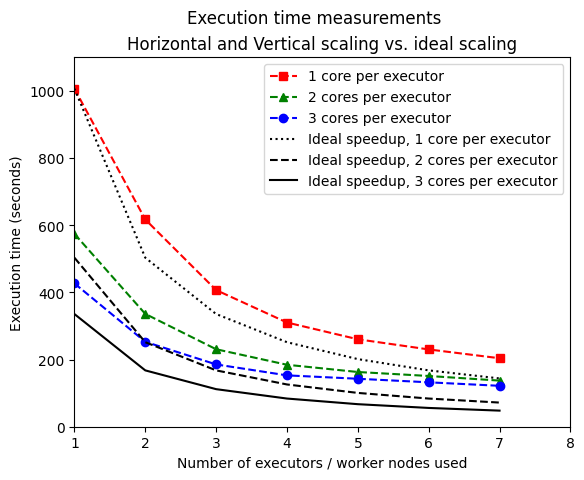

In [41]:
# Plotting runtime results
import matplotlib.pyplot as plt

nodes = [i for i in range(1,8)]

plt.plot(nodes,times[0],'--sr',label="1 core per executor")
plt.plot(nodes,times[1],'--^g',label="2 cores per executor")
plt.plot(nodes,times[2],'--ob',label="3 cores per executor")
plt.plot(nodes, [times[0][0]/i for i in nodes], ':k', label='Ideal speedup, 1 core per executor')
plt.plot(nodes, [times[0][0]/(2*i) for i in nodes], '--k', label='Ideal speedup, 2 cores per executor')
plt.plot(nodes, [times[0][0]/(3*i) for i in nodes], '-k', label='Ideal speedup, 3 cores per executor')
plt.legend()
plt.axis([1, 8, 0, 1100])
plt.xlabel("Number of executors / worker nodes used")
plt.ylabel("Execution time (seconds)")
plt.suptitle("Execution time measurements")
plt.title("Horizontal and Vertical scaling vs. ideal scaling")
plt.show()

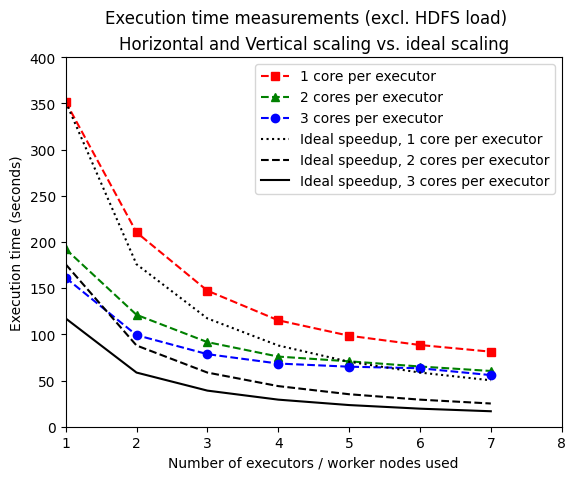

In [42]:
# Results not including loading the data from HDFS

plt.plot(nodes,times_without_load[0],'--sr',label="1 core per executor")
plt.plot(nodes,times_without_load[1],'--^g',label="2 cores per executor")
plt.plot(nodes,times_without_load[2],'--ob',label="3 cores per executor")
plt.plot(nodes, [times_without_load[0][0]/i for i in nodes], ':k', label='Ideal speedup, 1 core per executor')
plt.plot(nodes, [times_without_load[0][0]/(2*i) for i in nodes], '--k', label='Ideal speedup, 2 cores per executor')
plt.plot(nodes, [times_without_load[0][0]/(3*i) for i in nodes], '-k', label='Ideal speedup, 3 cores per executor')
plt.legend()
plt.axis([1, 8, 0, 400])
plt.xlabel("Number of executors / worker nodes used")
plt.ylabel("Execution time (seconds)")
plt.suptitle("Execution time measurements (excl. HDFS load)")
plt.title("Horizontal and Vertical scaling vs. ideal scaling")
plt.show()

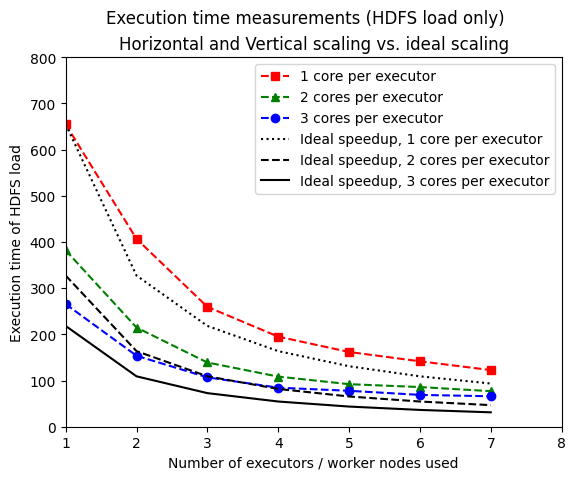

In [45]:
# Just load times

load_time = [[times[i][j] - times_without_load[i][j] for j in range(0,7)] for i in range(0,3)]

plt.plot(nodes,load_time[0],'--sr',label="1 core per executor")
plt.plot(nodes,load_time[1],'--^g',label="2 cores per executor")
plt.plot(nodes,load_time[2],'--ob',label="3 cores per executor")
plt.plot(nodes, [load_time[0][0]/i for i in nodes], ':k', label='Ideal speedup, 1 core per executor')
plt.plot(nodes, [load_time[0][0]/(2*i) for i in nodes], '--k', label='Ideal speedup, 2 cores per executor')
plt.plot(nodes, [load_time[0][0]/(3*i) for i in nodes], '-k', label='Ideal speedup, 3 cores per executor')
plt.legend()
plt.axis([1, 8, 0, 800])
plt.xlabel("Number of executors / worker nodes used")
plt.ylabel("Execution time of HDFS load")
plt.suptitle("Execution time measurements (HDFS load only)")
plt.title("Horizontal and Vertical scaling vs. ideal scaling")

plt.show()

In [46]:
import numpy as np
np.savetxt("runtimes.txt",np.array(times))
np.savetxt("runtimes_without_load.txt",np.array(times_without_load))
np.savetxt("runtimes_only_hdfs_load.txt",np.array(load_time))